In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR
from statsmodels.tsa.stattools import grangercausalitytests

# 1. Weekly Average Price and Weekly Average Trading Volume

In [67]:
bitcoin_weekly_price = pd.DataFrame.from_csv("Bitcoin Weekly Price Data.csv")
bitcoin_weekly_volume = pd.DataFrame.from_csv("Bitcoin Weekly Volume Data BTC.csv")

## Calculate first log differences

In [68]:
bitcoin_weekly_price_series = pd.Series(data=bitcoin_weekly_price["Weekly Average Price"])
bitcoin_weekly_price_series.head()

0     96.677143
1    133.834286
2    121.818571
3    113.905714
4    113.572857
Name: Weekly Average Price, dtype: float64

In [69]:
bitcoin_weekly_price_series_log = bitcoin_weekly_price_series.apply(np.log)
bitcoin_weekly_price_series_log_diff = bitcoin_weekly_price_series_log.diff()
bitcoin_weekly_price_series_log_diff = bitcoin_weekly_price_series_log_diff.drop(0)
bitcoin_weekly_price_series_log_diff.head()

1    0.325225
2   -0.094070
3   -0.067162
4   -0.002926
5    0.068116
Name: Weekly Average Price, dtype: float64

In [70]:
bitcoin_weekly_volume_series = pd.Series(data=bitcoin_weekly_volume["Average Volume per Week (BTC)"])
bitcoin_weekly_volume_series.head()

0    20202.562639
1    13204.207000
2    15670.144724
3    10198.091312
4     7279.517695
Name: Average Volume per Week (BTC), dtype: float64

In [71]:
bitcoin_weekly_volume_series_log = bitcoin_weekly_volume_series.apply(np.log)
bitcoin_weekly_volume_series_log_diff = bitcoin_weekly_volume_series_log.diff()
bitcoin_weekly_volume_series_log_diff = bitcoin_weekly_volume_series_log_diff.drop(0)
bitcoin_weekly_volume_series_log_diff.head()

1   -0.425274
2    0.171222
3   -0.429557
4   -0.337136
5   -0.042699
Name: Average Volume per Week (BTC), dtype: float64

Join the two dataframes:

In [72]:
a = {'Date': bitcoin_weekly_price["Date"] , 'Bitcoin WAP': bitcoin_weekly_price_series_log_diff, "Bitcoin WAV" : bitcoin_weekly_volume_series_log_diff}

In [73]:
bitcoin_volume_log_diff_and_bitcoin_price_log_diff = pd.DataFrame(a)
bitcoin_volume_log_diff_and_bitcoin_price_log_diff = bitcoin_volume_log_diff_and_bitcoin_price_log_diff.drop(0)
bitcoin_volume_log_diff_and_bitcoin_price_log_diff["Date"] = pd.to_datetime(bitcoin_volume_log_diff_and_bitcoin_price_log_diff["Date"])
bitcoin_volume_log_diff_and_bitcoin_price_log_diff = bitcoin_volume_log_diff_and_bitcoin_price_log_diff.set_index("Date")
bitcoin_volume_log_diff_and_bitcoin_price_log_diff.head()

,Bitcoin WAP,Bitcoin WAV
Date,,
2013-04-21,0.325225,-0.425274
2013-04-28,-0.094070,0.171222
2013-05-05,-0.067162,-0.429557
2013-05-12,-0.002926,-0.337136
2013-05-19,0.068116,-0.042699


## Create the VAR Model

In [74]:
data_1 = bitcoin_volume_log_diff_and_bitcoin_price_log_diff

In [75]:
model_1 = VAR(data_1)

## Lag order selection

In [76]:
model_1.select_order(15)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -6.015       -5.986     0.002443       -6.003
1        -6.196      -6.110*     0.002038      -6.161*
2       -6.202*       -6.059    0.002026*       -6.144
3        -6.197       -5.997     0.002036       -6.116
4        -6.197       -5.940     0.002036       -6.093
5        -6.195       -5.880     0.002040       -6.068
6        -6.200       -5.829     0.002029       -6.051
7        -6.174       -5.745     0.002084       -6.001
8        -6.158       -5.672     0.002118       -5.962
9        -6.145       -5.602     0.002145       -5.927
10       -6.129       -5.528     0.002182       -5.887
11       -6.102       -5.445     0.002240       -5.838
12       -6.085       -5.370     0.002280       -5.797
13       -6.060       -5.288     0.002339       -5.749
14       -6.038       -5.209     0.002392       -5.704
15       -

{'aic': 2, 'bic': 1, 'fpe': 2, 'hqic': 1}

In [77]:
results_1 = model_1.fit(maxlags=15, ic='bic')

## Regression Results

In [78]:
results_1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 31, May, 2018
Time:                     16:02:54
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -6.12323
Nobs:                     259.000    HQIC:                  -6.17250
Log likelihood:           74.6191    FPE:                 0.00201804
AIC:                     -6.20563    Det(Omega_mle):      0.00197209
--------------------------------------------------------------------
Results for equation Bitcoin WAP
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.010546         0.006441            1.637           0.103
L1.Bitcoin WAP         0.298800         0.058620            5.097           0.000
L1.Bitcoin WAV         0.004739         0.014069  

## Impulse Response Analysis

In [79]:
irf_1 = results_1.irf(5)

Without orthogonalization:

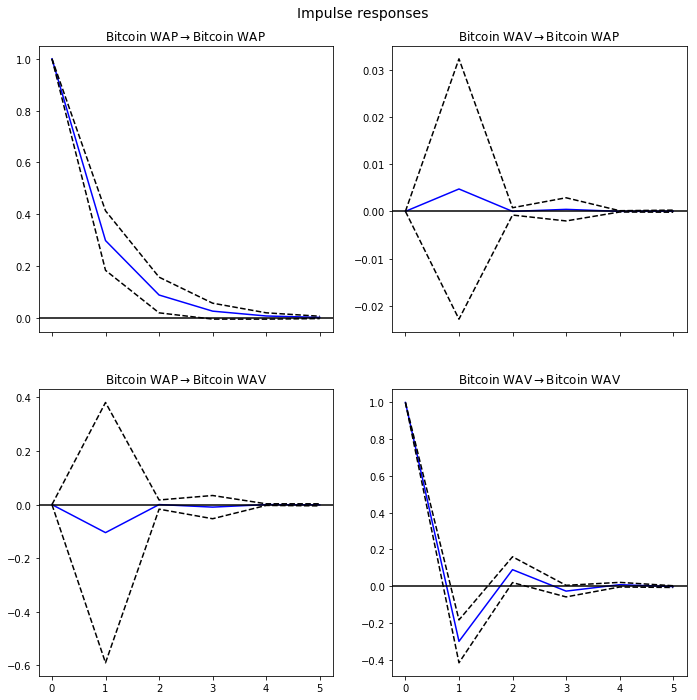

In [80]:
irf_1.plot()
plt.show()

## Granger Causality Test

In [81]:
results_1.test_causality("Bitcoin WAP", "Bitcoin WAV", kind="f")

Granger causality f-test
   Test statistic   Critical Value          p-value        df
-------------------------------------------------------------
         0.113451         3.859685            0.736  (1, 512)
H_0: ['Bitcoin WAV'] do not Granger-cause Bitcoin WAP
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 3.8596850369982239,
 'df': (1, 512),
 'pvalue': 0.73638687775929623,
 'signif': 0.05,
 'statistic': 0.11345104979418917}

In [82]:
results_1.test_causality("Bitcoin WAV", "Bitcoin WAP", kind="f")

Granger causality f-test
   Test statistic   Critical Value          p-value        df
-------------------------------------------------------------
         0.177787         3.859685            0.673  (1, 512)
H_0: ['Bitcoin WAP'] do not Granger-cause Bitcoin WAV
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 3.8596850369982239,
 'df': (1, 512),
 'pvalue': 0.67345873536040934,
 'signif': 0.05,
 'statistic': 0.17778726586685992}

# 2. Daily Price and Daily Trading Volume

In [83]:
bitcoin_daily_price = pd.DataFrame.from_csv("Bitcoin Daily Price Data.csv")
bitcoin_daily_volume = pd.DataFrame.from_csv("Bitcoin Daily Volume Data BTC.csv")

In [84]:
bitcoin_daily_price_series = pd.Series(data=bitcoin_daily_price["Daily Closing Price"])
bitcoin_daily_price_series.head()

0    257.62
1    254.54
2    255.92
3    260.20
4    271.50
Name: Daily Closing Price, dtype: float64

In [85]:
bitcoin_daily_price_series_log = bitcoin_daily_price_series.apply(np.log)
bitcoin_daily_price_series_log_diff = bitcoin_daily_price_series_log.diff()
bitcoin_daily_price_series_log_diff = bitcoin_daily_price_series_log_diff.drop(0)
bitcoin_daily_price_series_log_diff.head()

1   -0.012028
2    0.005407
3    0.016586
4    0.042512
5   -0.011074
Name: Daily Closing Price, dtype: float64

In [86]:
bitcoin_daily_volume_series = pd.Series(data=bitcoin_daily_volume["Volume (BTC)"])
bitcoin_daily_volume_series.head()

0    13395.153439
1     9826.994781
2     9153.852565
3     7909.856729
4    21362.613650
Name: Volume (BTC), dtype: float64

In [87]:
bitcoin_daily_volume_series_log = bitcoin_daily_volume_series.apply(np.log)
bitcoin_daily_volume_series_log_diff = bitcoin_daily_volume_series_log.diff()
bitcoin_daily_volume_series_log_diff = bitcoin_daily_volume_series_log_diff.drop(0)
bitcoin_daily_volume_series_log_diff.head()

1   -0.309760
2   -0.070958
3   -0.146065
4    0.993533
5   -0.064518
Name: Volume (BTC), dtype: float64

In [88]:
b = {'Date': bitcoin_daily_price["Date"] , 'Bitcoin DP': bitcoin_daily_price_series_log_diff, "Bitcoin DV" : bitcoin_daily_volume_series_log_diff}

In [89]:
bitcoin_volume_and_bitcoin_price_log_diff = pd.DataFrame(b)

In [90]:
bitcoin_volume_and_bitcoin_price_log_diff = bitcoin_volume_and_bitcoin_price_log_diff.drop(0)
bitcoin_volume_and_bitcoin_price_log_diff["Date"] = pd.to_datetime(bitcoin_volume_and_bitcoin_price_log_diff["Date"])
bitcoin_volume_and_bitcoin_price_log_diff = bitcoin_volume_and_bitcoin_price_log_diff.set_index("Date")
bitcoin_volume_and_bitcoin_price_log_diff.columns = ["Bitcoin DP", "Bitcoin DV"]
bitcoin_volume_and_bitcoin_price_log_diff.head()

,Bitcoin DP,Bitcoin DV
Date,,
2015-07-02,-0.012028,-0.309760
2015-07-03,0.005407,-0.070958
2015-07-04,0.016586,-0.146065
2015-07-05,0.042512,0.993533
2015-07-06,-0.011074,-0.064518


## Create the VAR Model

In [91]:
data_2 = bitcoin_volume_and_bitcoin_price_log_diff

In [92]:
model_2 = VAR(data_2)

## Lag order selection

In [93]:
model_2.select_order(15)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -7.675       -7.665    0.0004644       -7.671
1        -7.731       -7.702    0.0004390       -7.720
2        -7.786       -7.737    0.0004156       -7.767
3        -7.827       -7.758    0.0003988       -7.801
4        -7.843       -7.755    0.0003924       -7.810
5        -7.906       -7.798    0.0003686       -7.865
6        -7.929      -7.802*    0.0003601      -7.881*
7        -7.927       -7.780    0.0003609       -7.871
8        -7.931       -7.764    0.0003595       -7.868
9        -7.926       -7.740    0.0003611       -7.856
10       -7.922       -7.716    0.0003628       -7.844
11       -7.921       -7.696    0.0003630       -7.835
12       -7.933       -7.688    0.0003589       -7.840
13      -7.942*       -7.677   0.0003556*       -7.841
14       -7.936       -7.652    0.0003578       -7.828
15       -

{'aic': 13, 'bic': 6, 'fpe': 13, 'hqic': 6}

In [94]:
results_2 = model_2.fit(maxlags=15, ic='bic')

## Regression Results

In [95]:
results_2.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 31, May, 2018
Time:                     16:04:46
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -7.80100
Nobs:                     1012.00    HQIC:                  -7.87938
Log likelihood:           1165.33    FPE:                0.000360728
AIC:                     -7.92739    Det(Omega_mle):     0.000351636
--------------------------------------------------------------------
Results for equation Bitcoin DP
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.003191         0.001301            2.452           0.014
L1.Bitcoin DP         0.005921         0.031713            0.187           0.852
L1.Bitcoin DV         0.001676         0.002739        

## Impulse Response Analysis

In [96]:
irf_2 = results_2.irf(15)

Without orthogonalization:

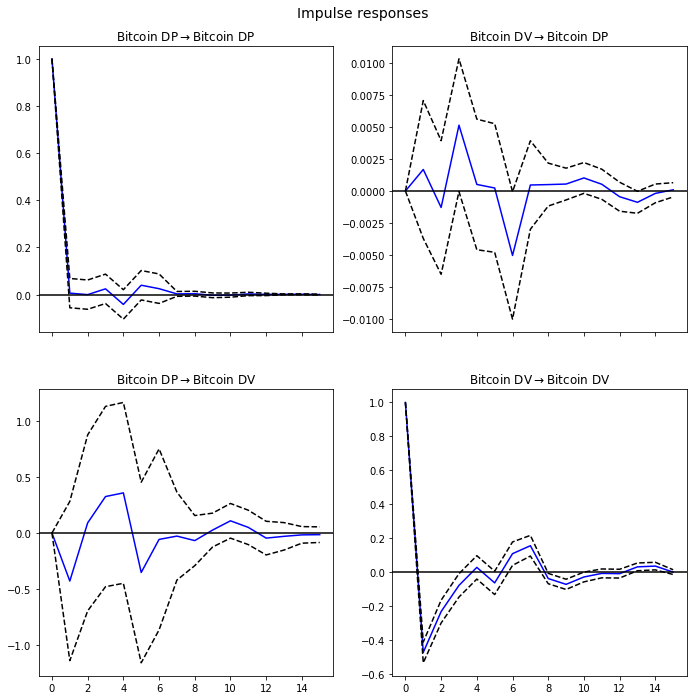

In [98]:
irf_2.plot()
plt.show()

In [99]:
results_2.test_causality("Bitcoin DP", "Bitcoin DV", kind="f")

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         1.326666         2.103115            0.242  (6, 1998)
H_0: ['Bitcoin DV'] do not Granger-cause Bitcoin DP
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 2.103114521247186,
 'df': (6, 1998),
 'pvalue': 0.24163170968988404,
 'signif': 0.05,
 'statistic': 1.3266655615586949}

In [100]:
results_2.test_causality("Bitcoin DV", "Bitcoin DP", kind="f")

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         0.491261         2.103115            0.815  (6, 1998)
H_0: ['Bitcoin DP'] do not Granger-cause Bitcoin DV
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 2.103114521247186,
 'df': (6, 1998),
 'pvalue': 0.81530192817171454,
 'signif': 0.05,
 'statistic': 0.49126126232342976}